In [1]:
import os
import xml.etree.ElementTree as ET
import pandas as pd

# Discovery

Before starting I need to understand the file type of the dataset, by listing all file in the directory and getting all file extension I can easily know the file type, therefore dealing with them accordingly.

In [2]:
# - os.listdir list all file in the directory
# - os.path.splittext divide the filename into filename and extension, it returns a tuple and 
# the second element is the extension
# - set returns the unique file extensions.
xml_list_files = os.listdir('/kaggle/input/nsf-research-awards-abstracts')
set([os.path.splitext(file)[1] for file in xml_list_files])

{'.xml'}

Since all files are XML, I'll be using ElemntTree from python that parse the file into a tree format to process and analyze it correctly.

The XML content starts at `rootTag` that nestes `Award`. It contains lot of information like the title, agency, award expiration date, award amount, abstract, and much more.

Since all this information not necessarly to classify all awards by topic, I'll be focusing in only three fields:

1. `AwardTitle`: This will serve as a summary on the abstract. *Hypothesis*: Provides context about the topic.
2. `Division`: The Division name could provide more information of the topic. *Hypothesis*: Each division will focus on knowledge areas.
3. `AbstractNarration`: The abstract of the award, this has the more useful information to clusterize.

In [3]:
tree = ET.parse('/kaggle/input/nsf-research-awards-abstracts/2000009.xml')
root = tree.getroot()
award = root.find("Award")
for child in award:
    print(child.tag)

AwardTitle
AGENCY
AwardEffectiveDate
AwardExpirationDate
AwardTotalIntnAmount
AwardAmount
AwardInstrument
Organization
ProgramOfficer
AbstractNarration
MinAmdLetterDate
MaxAmdLetterDate
ARRAAmount
TRAN_TYPE
CFDA_NUM
NSF_PAR_USE_FLAG
FUND_AGCY_CODE
AWDG_AGCY_CODE
AwardID
Investigator
Institution
Performance_Institution
ProgramElement
ProgramReference
ProgramReference
ProgramReference
Appropriation
Fund
FUND_OBLG
POR


The dataset contains more than 13 thousand documents. To optimize the consumptions I'll be using iterators. My first thought was to use recursive functions; however, python has a limitation in the maximum recursion depth.

On the other hand, iterators are lazy evaluators, being helpful to read a lot of files only when needed.

To be more memory efficient, first I'll split the `xml_list_files` into training and test set. After that, I'll create batches on training data, so the consumptions will be faster.

In [4]:
# Recursive function. Not used because of maximum recursion depth
# def parsing_docs(doc_list):
#     docs = []
#     directory = '/kaggle/input/nsf-research-awards-abstracts/'
    
#     # recursive case
#     if len(doc_list) > 0:
#         doc = doc_list[0]
#         full_dir = os.path.join(directory, doc)
#         award_title = ET.parse(full_dir).find("./Award/AwardTitle")
#         organization = ET.parse(full_dir).find("./Award/Organization")
#         abstract_narration = ET.parse(full_dir).find("./Award/AbstractNarration")
#         docs.append((award_title, organization, abstract_narration))
#         docs.extend(parsing_docs(doc_list[1:]))
        
#     return docs

In [5]:
from sklearn.model_selection import train_test_split

# Split the list into train and test
train_list, test_list = train_test_split(xml_list_files, test_size=0.33, shuffle=True)

In [6]:
class CreateTrainingBatches:
    """
    This class is used to yield an iterator of fixed size. Size is calculated during initialization and used the
    training size and the number of batches to produce the output. Number of batches is configurable
    """
    
    def __init__(self, train_set, num_batches=4):
        self.__train_set = train_set
        # Define the batch size and the number of batches
        self.__num_batches = num_batches
        self.__train_size = len(self.__train_set)
        self.__batch_size = round(self.__train_size / self.__num_batches)
        
    def create_batches(self):
        # Yield an iterator
        for i in range(self.__num_batches):
            yield self.__train_set[i*self.__batch_size:(i+1)*self.__batch_size]

In [7]:
class XMLProcessor:
    """
    Class dedicated to process XML, the input must be an iterator, so the processing is the most memory efficient as possible.
    The process method will read the input iterator each time is called, when the iterator is empty, it will print a message.
    """
    
    def __init__(self, batches: iter):
        self.__batches = batches
    
    def filter_xml_element(self, file_path):
        """
        Filter the tasg of interest. This function can be modified to get any other tag of interest.
        However, changing this implies to modify the convert_to_dataframe function and the get_text_elements
        in case the new tag needs further processing.
        """
        tags_of_interest = {'AwardTitle','Organization','AbstractNarration'}
        context = ET.iterparse(file_path)
        return filter(lambda xml: xml[1].tag in tags_of_interest, context)

    def process_files(self, xml_file):
        """
        Maps the filtering functions to each xml.
        """
        return map(lambda file: self.filter_xml_element(file), xml_file)

    def prepare_files(self, lst):
        """
        The input list is full of names only. This function concat the 
        XML directory to the filename.
        """
        xml_dir = '/kaggle/input/nsf-research-awards-abstracts'
        return map(lambda file: os.path.join(xml_dir, file), lst)

    def get_text_elements(self, xml):
        """
        It get the text data from the filtered tags. Only organization recieves a particular
        case since the function looks for Division - LongName.
        """
        if xml[1].tag == 'Organization':
            # Search for Division tag inside Organization
            division = [elem for elem in xml[1] if elem.tag == 'Division']
            # Inside Division, search to LongName (the name of the division)
            long_name = [elem for elem in division[0] if elem.tag == 'LongName']
            return long_name[0].text
        else:
            return xml[1].text

    def get_data_from_generator(self, data):
        """
        It maps the get_text_element to generate a list of text data
        """
        return [map(lambda x: self.get_text_elements(x), elem) for elem in data]

    def convert_to_dataframe(self, text_data):
        """
        Conver the input text in list format into a dataframe for further processing
        """
        return pd.DataFrame(
            data=[list(data) for data in text_data],
            columns=['AwardTitle','Division','AbstractNarration']
        )

    def process(self):
        """
        Main function of the class
        """
        try:
            lst = next(self.__batches)

            xml_files = self.prepare_files(lst)
            xml_data = self.process_files(xml_files)
            xml_text_data = self.get_data_from_generator(xml_data)
            return self.convert_to_dataframe(xml_text_data).assign(file = lst)
        except StopIteration:
            print("Iterator is empty")

In [8]:
batch_gen = CreateTrainingBatches(train_list)
it = batch_gen.create_batches()

xml_pr = XMLProcessor(it)
# This method will generate a new dataframe each time is called.
# This way I can explore a sample of 2 thousand records and, when needed, call the next 2 thounsand until the iterator is empty
# When the last one occurs, it will print a message.
df1 = xml_pr.process()

In [9]:
def read_single_xml(file):
    xml_dir = '/kaggle/input/nsf-research-awards-abstracts'
    filename = os.path.join(xml_dir, file)
    return ET.parse(filename)

# EDA

To begin, I start with a sample of the training set doing the following steps:

1. **Remove empty records:** Since we are trying to clusterize all the XML, it is necessary to understand the context of the data including the empty records. This will help me understand if there are files that required special treatment and decided whether the effort is worthy. In case their emptiness is because the XML file comes in that format or the effort is not worthy because of the impact into the data, I will drop them instead.
2. **Convert all text to lowercase:** Doing NLP requirest to standarize incoming text. To do so, the first step is lowercast everything.
3. **Remove punctuation:** Dots, commas, semicolon, etc. doesn't provide any relevant information to context of the string.
4. **Define and remove stopwords:** These are repetitive words like `the`, `is`, `are`, etc. Since they are mayority in any text, they will introduce noise into the model when trying to identify patterns.
5. **Lemmatization:** Reduce words to their base form. For example, running into run. This reduce the vocabulary necessary to be learned.

In [10]:
# I didn't expect to have empty values in AbstractNarration. 
# They are not a lot, I can assume that the other training batches have more or less the same number of empty AbstractNarration columns (they are shuffled)
# Just to confirm that I'm not missing something, I will get one of this files and reviwed by hand to ensure there are not exceptions.
df1.isna().sum()

AwardTitle            0
Division              0
AbstractNarration    25
file                  0
dtype: int64

In [11]:
df1.query("AbstractNarration.isna()")

,AwardTitle,Division,AbstractNarration,file
216,iEdison,General Counsel,None,2035012.xml
218,Intergovernmental Mobility Assignment (11/12/1...,Division Of Ocean Sciences,None,2010264.xml
268,III: Small: RUI: Collaborative Research: Model...,Div Of Information & Intelligent Systems,None,2007128.xml
295,Intergovernmental Personnel Award,"Div Of Civil, Mechanical, & Manufact Inn",None,2050306.xml
343,Intergovernmental Personnel Award,"Div Of Chem, Bioeng, Env, & Transp Sys",None,2016297.xml
442,"NIWC IT Security Support, FY21",Office of Polar Programs (OPP),None,2041114.xml
601,Intergovernmental Mobility Assignment,Division Of Materials Research,None,2050333.xml
629,OIG Security Investigations,Office Of Inspector General,None,2016785.xml
743,The Intergovernmental Personnel Act (IPA) assi...,Division Of Astronomical Sciences,None,2013254.xml
793,FY2020 CFOC Federal Interagency Management Cou...,"Office of Budget, Finance, & Award Management",None,2040236.xml


In [12]:
# Seems that they are just empty. I will drop all empty records on AbstractNarration.
for child in read_single_xml("2051285.xml").find('./Award/AbstractNarration'):
    print(child.tag, child.attrib)
    
for child in read_single_xml("2026426.xml").find('./Award/AbstractNarration'):
    print(child.tag, child.attrib)

In [13]:
df1.dropna(subset=["AbstractNarration"], inplace=True)

In [14]:
import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [15]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower().translate(str.maketrans('','',string.punctuation))
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df1['AwardTitle_clean'] = df1.AwardTitle.apply(clean_text)
df1['Division_clean'] = df1.Division.apply(clean_text)
df1['AbstractNarration_clean'] = df1.AbstractNarration.apply(clean_text)

In [16]:
# Now, surely there are a bunch of words that are similar to each other, for example, the division_clean column has two different ways to refers to word
# "division": Division and div.
df1.head()

,AwardTitle,Division,AbstractNarration,file,AwardTitle_clean,Division_clean,AbstractNarration_clean
0,CAREER: Community Organizing for Datafied Worlds,Div Of Information & Intelligent Systems,This project describes how professional commun...,2047255.xml,career community organizing datafied world,div information intelligent system,project describes professional community organ...
1,Dynamic Discrete Choice Estimation with Partia...,"Div Of Civil, Mechanical, & Manufact Inn",This award will investigate rigorous methods f...,2048395.xml,dynamic discrete choice estimation partially o...,div civil mechanical manufact inn,award investigate rigorous method datadriven m...
2,Ion and ligand interactions of hyaluronic acid,Division Of Materials Research,NONTECHNICAL ABSTRACT<br/>Hyaluronic acid is a...,2005189.xml,ion ligand interaction hyaluronic acid,division material research,nontechnical abstractbrhyaluronic acid biologi...
3,High-intensity focused ultrasound (HIFU) energ...,"Div Of Chem, Bioeng, Env, & Transp Sys",High-intensity focused ultrasound (HIFU) ablat...,2045234.xml,highintensity focused ultrasound hifu energize...,div chem bioeng env transp sys,highintensity focused ultrasound hifu ablation...
4,CAREER: Designing a Synthetic Nucleolus for Ce...,Division Of Materials Research,Non-Technical Abstract: <br/><br/>This researc...,2045454.xml,career designing synthetic nucleolus cell free...,division material research,nontechnical abstract brbrthis research develo...


## Word exploration

As part of the EDA, I'm visualizing and seeing the most common words.

Focusing particularly in the Division name, I saw there a lot of abbreviations that should be managed. I'm *supposing* that the division will help to build a knowledge herarchy since I found words like `system`, `mathematical` and `education`.

The approach I'll be using to deal with abbreviations is using a fuzzy matching to identify most related words.

To identify abbreviations I will plot a histogram of the number of letters in a word to get the cut-off point bettween abbreviations and whole words.

In [17]:
# I'm getting the 20 most common words to start with a exploration.
from collections import Counter

award_title_words = Counter(' '.join(df1['AwardTitle_clean']).split()).most_common(20)
division_name_words = Counter(' '.join(df1['Division_clean']).split()).most_common(20)
abstract_narration_words = Counter(' '.join(df1['AbstractNarration_clean']).split()).most_common(20)

In [18]:
# Example of abbreviations are division and div; system and sys. 
division_name_words

[('division', 1187),
 ('div', 634),
 ('science', 505),
 ('system', 268),
 ('sys', 182),
 ('translational', 176),
 ('impact', 176),
 ('mathematical', 162),
 ('education', 155),
 ('research', 134),
 ('computer', 126),
 ('network', 126),
 ('civil', 117),
 ('mechanical', 117),
 ('manufact', 117),
 ('inn', 117),
 ('undergraduate', 111),
 ('chem', 107),
 ('bioeng', 107),
 ('env', 107)]

In [19]:
div_vocab = Counter(' '.join(df1['Division_clean']).split()).keys()

In [20]:
from fuzzywuzzy import fuzz, process
print(process.extractBests("div", div_vocab)[1:2])
print(process.extractBests("sys", div_vocab)[1:2])

[('division', 90)]
[('system', 90)]


/opt/conda/lib/python3.10/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [21]:
from fuzzywuzzy import fuzz, process

# Function to find the closest match using fuzzy matching
def fuzzy_match_abbreviation(words, full_terms):
    return [process.extractBests(word, full_terms, limit=3) for word in words]
#     return ' '.join([process.extractOne(word, full_terms)[0] if fuzz.ratio(word, process.extractOne(word, full_terms)[0]) > 80 else word for word in words])

# Apply fuzzy matching on the relevant text columns
# df['AwardTitle_fuzzy'] = df['AwardTitle_clean'].apply(lambda x: fuzzy_match_abbreviation(x, full_terms))


In [22]:
fuzzy_match_abbreviation(div_vocab, div_vocab)

[[('div', 100), ('division', 90), ('divn', 86)],
 [('information', 100), ('innovation', 76), ('foundation', 67)],
 [('intelligent', 100), ('inn', 60), ('env', 60)],
 [('system', 100), ('sys', 90), ('stem', 90)],
 [('civil', 100), ('activity', 72), ('div', 60)],
 [('mechanical', 100), ('mathematical', 64), ('behavioral', 60)],
 [('manufact', 100), ('oac', 60), ('impact', 57)],
 [('inn', 100), ('innovation', 90), ('information', 60)],
 [('division', 100), ('div', 90), ('divn', 68)],
 [('material', 100), ('mathematical', 70), ('internatl', 59)],
 [('research', 100), ('re', 90), ('earth', 72)],
 [('chem', 100), ('chemistry', 90), ('mathematical', 68)],
 [('bioeng', 100), ('biology', 62), ('bioscience', 62)],
 [('env', 100), ('environmental', 90), ('intelligent', 60)],
 [('transp', 100), ('translational', 75), ('organismal', 60)],
 [('sys', 100), ('system', 90), ('ecosystem', 90)],
 [('office', 100), ('oiaoffice', 90), ('chem', 60)],
 [('polar', 100), ('oac', 60), ('re', 60)],
 [('program',

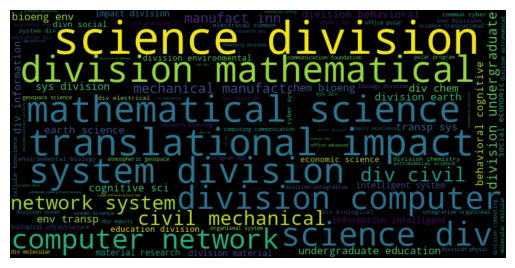

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, max_words=100).generate(' '.join(df1['Division_clean']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()